# Simple Moving Average

In [21]:
import pandas as pd
import asyncio
import logging
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from backtest.dtype.instrument import Instrument, Instruments
from backtest.schema.instrument_schema import instrument_schema
from backtest.orderbook.file_data_source import FileDataSource
from backtest.detail.clock import Clock
from backtest.application.backtest import Backtest
from backtest.util import int_to_dt

logging.basicConfig(level=logging.DEBUG)
matplotlib.pyplot.set_loglevel (level = 'warning')
pil_logger = logging.getLogger('PIL')  
pil_logger.setLevel(logging.WARN)
filename = "/tmp/btcusdt_20230908.dat.gz"

## 1. Load tick data from file

In [22]:

instrument = instrument_schema["binance"]["perpetual"]["btc-usdt"]
trading_pair= instrument.trading_pair
trading_pairs = [trading_pair,]
instruments = Instruments({instrument.trading_pair: instrument})
filenames = {instrument.trading_pair: filename}
max_lines = 500_000 / 4  # Read this much lines, 0 to read all
data_source = FileDataSource(filenames=filenames, instruments=instruments, max_lines=max_lines, verbose=False)

tick_size = 1_000_000_000 # 1s
start_time = data_source.start_time()
end_time = data_source.end_time()
print("start_time: {} end_time: {}".format(int_to_dt(start_time/10**9), int_to_dt(end_time/10**9)))
clock = Clock(tick_size=tick_size, start_time=start_time, end_time=end_time)
clock.add_iterator(data_source)


Loading BTC-USDT /tmp/btcusdt_20230908.dat.gz:  19%|██████████████▍                                                               | 36440505/196163872 [00:06<00:27, 5766417.66it/s]

start_time: 2023-09-08 03:30:16.257220 end_time: 2023-09-08 03:54:51.739913


## 2. Create Backtest instance

In [23]:
from backtest.indicator.ma import MovingAverage

price_precision = instrument.price_precision

class SMA(Backtest):
    def __init__(self, **kwargs):
        Backtest.__init__(self, **kwargs)
        self._tick_count = 0
        self._prices = {}
        self._indicators = {}
        self._smas = {}
        self._buys = {}
        self._sells = {}
        for trading_pair in self.trading_pairs:
            self._prices[trading_pair] = []
            self._indicators[trading_pair] = MovingAverage(20)
            self._smas[trading_pair] = []
            self._buys[trading_pair] = []
            self._sells[trading_pair] = []
    
    def tick(self, timestamp: float):
        self._tick_count += 1
        ts = timestamp/10**9
        for trading_pair in self.trading_pairs:
            try:
                price = self.get_mid_price(trading_pair)/price_precision
                self._prices[trading_pair].append([ts, price])

                indicator = self._indicators[trading_pair]
                indicator.add_sample(price)
                self._smas[trading_pair].append([ts, indicator.current_value])
                #if self._tick_count % 100:
                #    print(f"BacktestCustom.tick {int_to_dt(timestamp/10**9)} {trading_pair} price: {self.get_mid_price(trading_pair)}")
                if len(self._prices[trading_pair]) < 2 or len(self._smas[trading_pair]) < 2:
                    continue
                prev_price, current_price = self._prices[trading_pair][-2][1], self._prices[trading_pair][-1][1]
                prev_ma, current_ma = self._smas[trading_pair][-2][1], self._smas[trading_pair][-1][1]                
                if current_price > current_ma and prev_price < prev_ma:
                    print(f"---SMA.tick {int_to_dt(ts)} BUY signal price: {current_price}")
                    self._buys[trading_pair].append([ts, current_price])
                elif current_price < current_ma and prev_price > prev_ma:
                    print(f"---SMA.tick {int_to_dt(ts)} SELL signal price: {current_price}")
                    self._sells[trading_pair].append([ts, current_price])
            except Exception as e:
                logging.error(f"SMA.tick e: {e}")

instruments = Instruments(instruments={instrument.trading_pair: instrument})
model = SMA(config={}, instruments=instruments, data_source=data_source, verbose=False)
clock.add_iterator(model)
clock.backtest_til()
model.stop(clock)

---SMA.tick 2023-09-08 03:30:44.257220 SELL signal price: 26224.05
---SMA.tick 2023-09-08 03:31:20.257220 BUY signal price: 26223.65
---SMA.tick 2023-09-08 03:32:25.257220 SELL signal price: 26223.85
---SMA.tick 2023-09-08 03:32:54.257220 BUY signal price: 26221.95
---SMA.tick 2023-09-08 03:35:51.257220 SELL signal price: 26243.55
---SMA.tick 2023-09-08 03:36:47.257220 BUY signal price: 26244.05
---SMA.tick 2023-09-08 03:37:08.257220 SELL signal price: 26244.85
---SMA.tick 2023-09-08 03:37:42.257220 BUY signal price: 26243.55
---SMA.tick 2023-09-08 03:38:01.257220 SELL signal price: 26243.55
---SMA.tick 2023-09-08 03:38:51.257220 BUY signal price: 26248.55
---SMA.tick 2023-09-08 03:39:15.257220 SELL signal price: 26248.85
---SMA.tick 2023-09-08 03:39:57.257220 BUY signal price: 26246.85
---SMA.tick 2023-09-08 03:41:51.257220 SELL signal price: 26253.55
---SMA.tick 2023-09-08 03:42:03.257220 BUY signal price: 26254.95
---SMA.tick 2023-09-08 03:42:05.257220 SELL signal price: 26252.05
--

## 3. Plot Price, Signal, Buys, and Sells

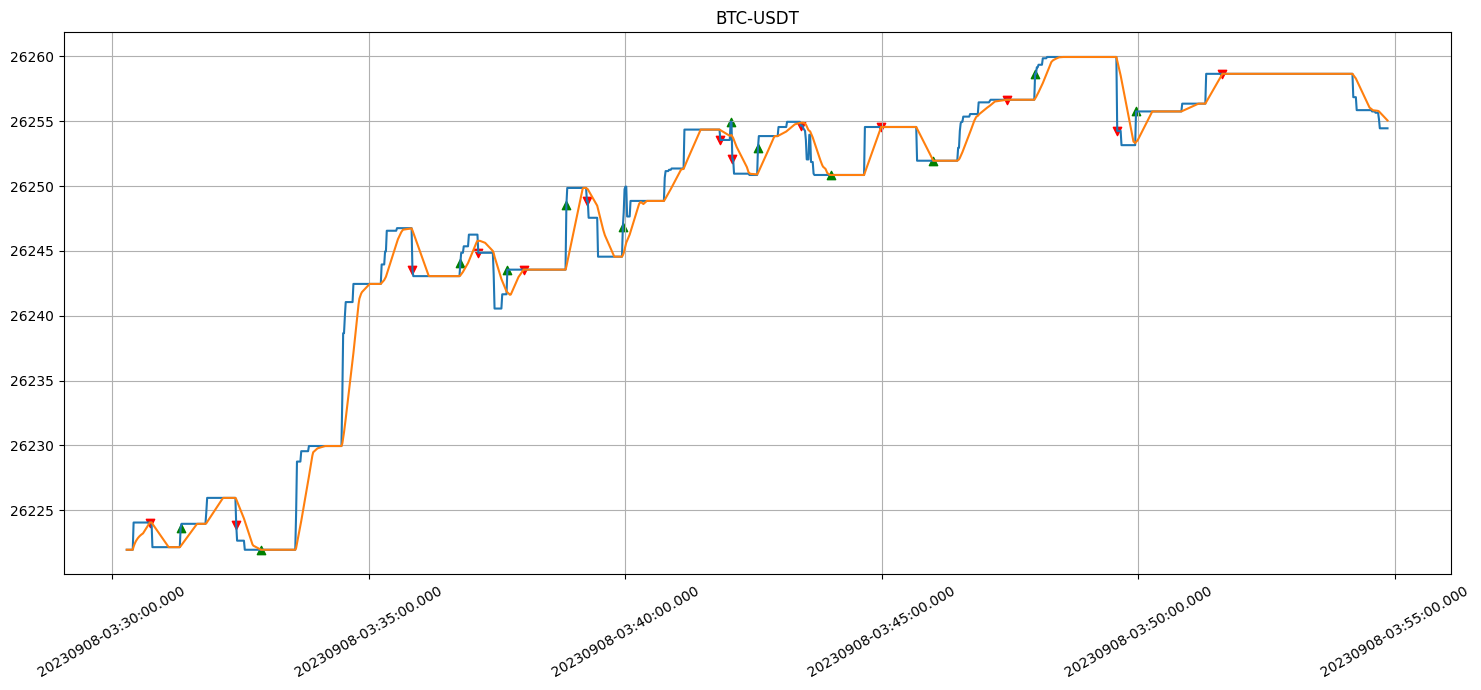

In [24]:
prices = np.array(model._prices[trading_pair])
price_dates = [int_to_dt(i) for i in prices[:, 0]]
sma = np.array(model._smas[trading_pair])
sma_dates = [int_to_dt(i) for i in sma[:, 0]]
buys = np.array(model._buys[trading_pair])
buy_dates = [int_to_dt(i) for i in buys[:, 0]]
sells = np.array(model._sells[trading_pair])
sell_dates = [int_to_dt(i) for i in sells[:, 0]]

fig, axs = plt.subplots(1, 1, clear=True, figsize=(15,7))
axs.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: mdates.DateFormatter('%Y%m%d-%H:%M:%S.%f')(x)[:-3])
)      
axs.plot(price_dates, prices[:, 1])
axs.plot(sma_dates, sma[:, 1])
axs.scatter(buy_dates, buys[:, 1], marker="^", color="g")
axs.scatter(sell_dates, sells[:, 1], marker="v", color="r")
axs.xaxis.set_tick_params(rotation=30)
axs.grid("-")
axs.set_title("BTC-USDT")
plt.tight_layout()
plt.show()